# Machine Learning on gut microbiota of patients with Colorectal cancer (4): Differential Analysis


There are 19 species in our dataset. In order to clinically interpret the potential biomarkers identified by the next step in machine learning, we perform the differetial analysis to figure out the significant species as the inputs for building models. The method and criterion are as follows:

* T-test based on CLR tranformed data;
* Pvalue or Adjusted-Pvalue is less than 0.05;
* the absolute values of Log2Foldchange on Mean values is more than 1.

## Goal

Find the significant features of the data and choose them for machine learning. 

## Loading data and essential libraries

In [1]:
import pandas as pd 
import numpy as np

data_df = pd.read_table('./dataset/MergeData_clr.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

,disease,s__Bacteroides_plebeius,s__Bacteroides_dorei,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Bacteroides_ovatus,s__Parabacteroides_distasonis,s__Ruminococcus_gnavus,s__Phascolarctobacterium_faecium,s__Bacteroides_uniformis,...,s__Bacteroides_finegoldii,s__Haemophilus_sp_HMSC71H05,s__Clostridium_saccharolyticum,s__Streptococcus_anginosus_group,s__Streptococcus_sp_A12,s__Klebsiella_pneumoniae,s__Bacteroides_coprocola,s__Ruminococcus_lactaris,s__Turicimonas_muris,s__Proteobacteria_bacterium_CAG_139
0,healthy,10.262146,8.532694,7.729839,7.605931,7.477464,7.267232,7.074996,6.832596,6.738413,...,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779,-3.441779
1,healthy,7.609333,4.466872,6.654823,4.236672,4.697277,3.518645,2.603642,-3.929140,5.619399,...,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140,-3.929140
2,healthy,8.411267,7.884081,7.668467,-3.379905,6.577229,6.474488,6.883446,-3.379905,6.725545,...,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905,-3.379905
3,healthy,6.261269,6.939669,5.819509,4.064784,4.026179,7.227381,3.407265,-3.632294,6.170285,...,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294,-3.632294
4,CRC,-0.026692,5.697435,3.808831,4.253082,4.284986,5.784833,6.384592,-5.007660,5.492187,...,4.187313,2.872359,2.219946,0.713786,-5.007660,-5.007660,-5.007660,-5.007660,-5.007660,-5.007660


## T test

Since profile are CLR transformed data, we choose t test to identify the significant species

In [23]:
from itertools import combinations
from scipy import stats as st


def all_pairwise(df, compare_col = 'disease'):

    decade_pairs = [(i, j) for i, j in combinations(df[compare_col].unique().tolist(), 2)]
    # or add a list of colnames to function signature
    cols = list(df.columns)
    cols.remove(compare_col)
    list_of_dfs = []
    for pair in decade_pairs:
        for col in cols:
            c1 = df[df[compare_col] == pair[0]][col]
            c2 = df[df[compare_col] == pair[1]][col]
            results = st.ttest_ind(c1, c2, nan_policy='omit')
            tmp = pd.DataFrame({'dec1': pair[0],
                                'dec2': pair[1],
                                'tstat': results.statistic,
                                'pvalue': results.pvalue}, index = [col])
            list_of_dfs.append(tmp)
    df_stats = pd.concat(list_of_dfs)

    return df_stats

ttest_res = all_pairwise(data)

ttest_res.head()

,dec1,dec2,tstat,pvalue
s__Bacteroides_plebeius,healthy,CRC,-3.092931,0.002092
s__Bacteroides_dorei,healthy,CRC,2.025927,0.043301
s__Faecalibacterium_prausnitzii,healthy,CRC,3.155606,0.001698
s__Eubacterium_eligens,healthy,CRC,3.104121,0.002016
s__Bacteroides_ovatus,healthy,CRC,-1.936173,0.053408


* FDR correction


In [25]:
def correct_pvalues_for_multiple_testing(pvalues, correction_type = "Benjamini-Hochberg"):                
    """                                                                                                   
    consistent with R - print correct_pvalues_for_multiple_testing([0.0, 0.01, 0.029, 0.03, 0.031, 0.05, 0.069, 0.07, 0.071, 0.09, 0.1]) 
    """
    from numpy import array, empty                                                                        
    pvalues = array(pvalues) 
    #n = float(pvalues.shape[0])
    n = pvalues.shape[0]                                                                        
    new_pvalues = empty(n)
    if correction_type == "Bonferroni":                                                                   
        new_pvalues = n * pvalues
    elif correction_type == "Bonferroni-Holm":                                                            
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        for rank, vals in enumerate(values):                                                              
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue                                                            
    elif correction_type == "Benjamini-Hochberg":                                                         
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        values.reverse()                                                                                  
        new_values = []
        for i, vals in enumerate(values):                                                                 
            rank = n - i
            pvalue, index = vals                                                                          
            new_values.append((n/rank) * pvalue)                                                          
        for i in range(0, int(n)-1):  
            if new_values[i] < new_values[i+1]:                                                           
                new_values[i+1] = new_values[i]                                                           
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]
                                                                                                               
    return new_pvalues

ttest_res['Adjusted-pvalue'] = correct_pvalues_for_multiple_testing(ttest_res['pvalue'], correction_type = "Benjamini-Hochberg")
ttest_res_sort = ttest_res.sort_values(by='Adjusted-pvalue')
ttest_res_sort.head()

,dec1,dec2,tstat,pvalue,Adjusted-pvalue
s__Parvimonas_micra,healthy,CRC,-5.688678,2.177233e-08,0.000003
s__Roseburia_faecis,healthy,CRC,4.420148,1.209594e-05,0.000913
s__Collinsella_aerofaciens,healthy,CRC,-4.015717,6.832673e-05,0.003439
s__Actinomyces_sp_HMSC035G02,healthy,CRC,-3.529501,4.546367e-04,0.017163
s__Roseburia_intestinalis,healthy,CRC,3.438384,6.338623e-04,0.019143


* Significant species with adjusted-pvalue less than 0.1

In [29]:
threshold = 0.05 # pvalue or Adjusted-pvalue
signif_species = ttest_res_sort.loc[ttest_res_sort['pvalue'] < threshold]
signif_species.shape

(40, 5)

There are 40 significant species identified by pvalue between CRC and healthy group

## Output

Selecting the 40 species profile to downstream analysis

In [51]:
data_signif = pd.concat([data['disease'], data[signif_species.index.tolist()]], axis=1)


data_signif.to_csv('./dataset/MergeData_clr_signif.tsv',
            sep='\t', encoding='utf-8', index=True)

data_signif.head()

,disease,s__Parvimonas_micra,s__Roseburia_faecis,s__Collinsella_aerofaciens,s__Actinomyces_sp_HMSC035G02,s__Roseburia_intestinalis,s__Bacteroides_plebeius,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Ruminococcus_bicirculans,...,s__Bacteroides_caccae,s__Alistipes_shahii,s__Fusobacterium_mortiferum,s__Bacteroides_dorei,s__Bifidobacterium_pseudocatenulatum,s__Blautia_wexlerae,s__Haemophilus_parainfluenzae,s__Turicimonas_muris,s__Gemella_haemolysans,s__Bifidobacterium_longum
0,healthy,-3.441779,-3.441779,6.576766,-3.441779,-3.441779,10.262146,7.729839,7.605931,-3.441779,...,-3.441779,0.667517,-3.441779,8.532694,-3.441779,6.386041,4.686443,-3.441779,-3.441779,6.717971
1,healthy,-3.929140,5.691656,4.532923,-3.929140,6.393962,7.609333,6.654823,4.236672,4.372945,...,3.844374,1.704619,-3.929140,4.466872,3.229868,2.122180,2.479674,-3.929140,-3.929140,4.429797
2,healthy,-0.407520,7.383588,-3.379905,1.248080,3.614452,8.411267,7.668467,-3.379905,5.890776,...,5.935044,3.038147,-3.379905,7.884081,-3.379905,7.163770,2.015644,-3.379905,2.332939,-3.379905
3,healthy,-3.632294,5.307481,5.897842,-3.632294,3.636733,6.261269,5.819509,4.064784,-3.632294,...,-3.632294,3.401043,3.295942,6.939669,1.234944,3.370701,-3.632294,-3.632294,-3.632294,3.089479
4,CRC,2.320322,-5.007660,4.759592,-1.450665,-5.007660,-0.026692,3.808831,4.253082,2.034727,...,-5.007660,5.167885,-5.007660,5.697435,1.727297,2.949174,2.203556,-5.007660,0.273296,3.893588


## correlation matrix

<AxesSubplot: title={'center': 'CRC Species Correlation'}>

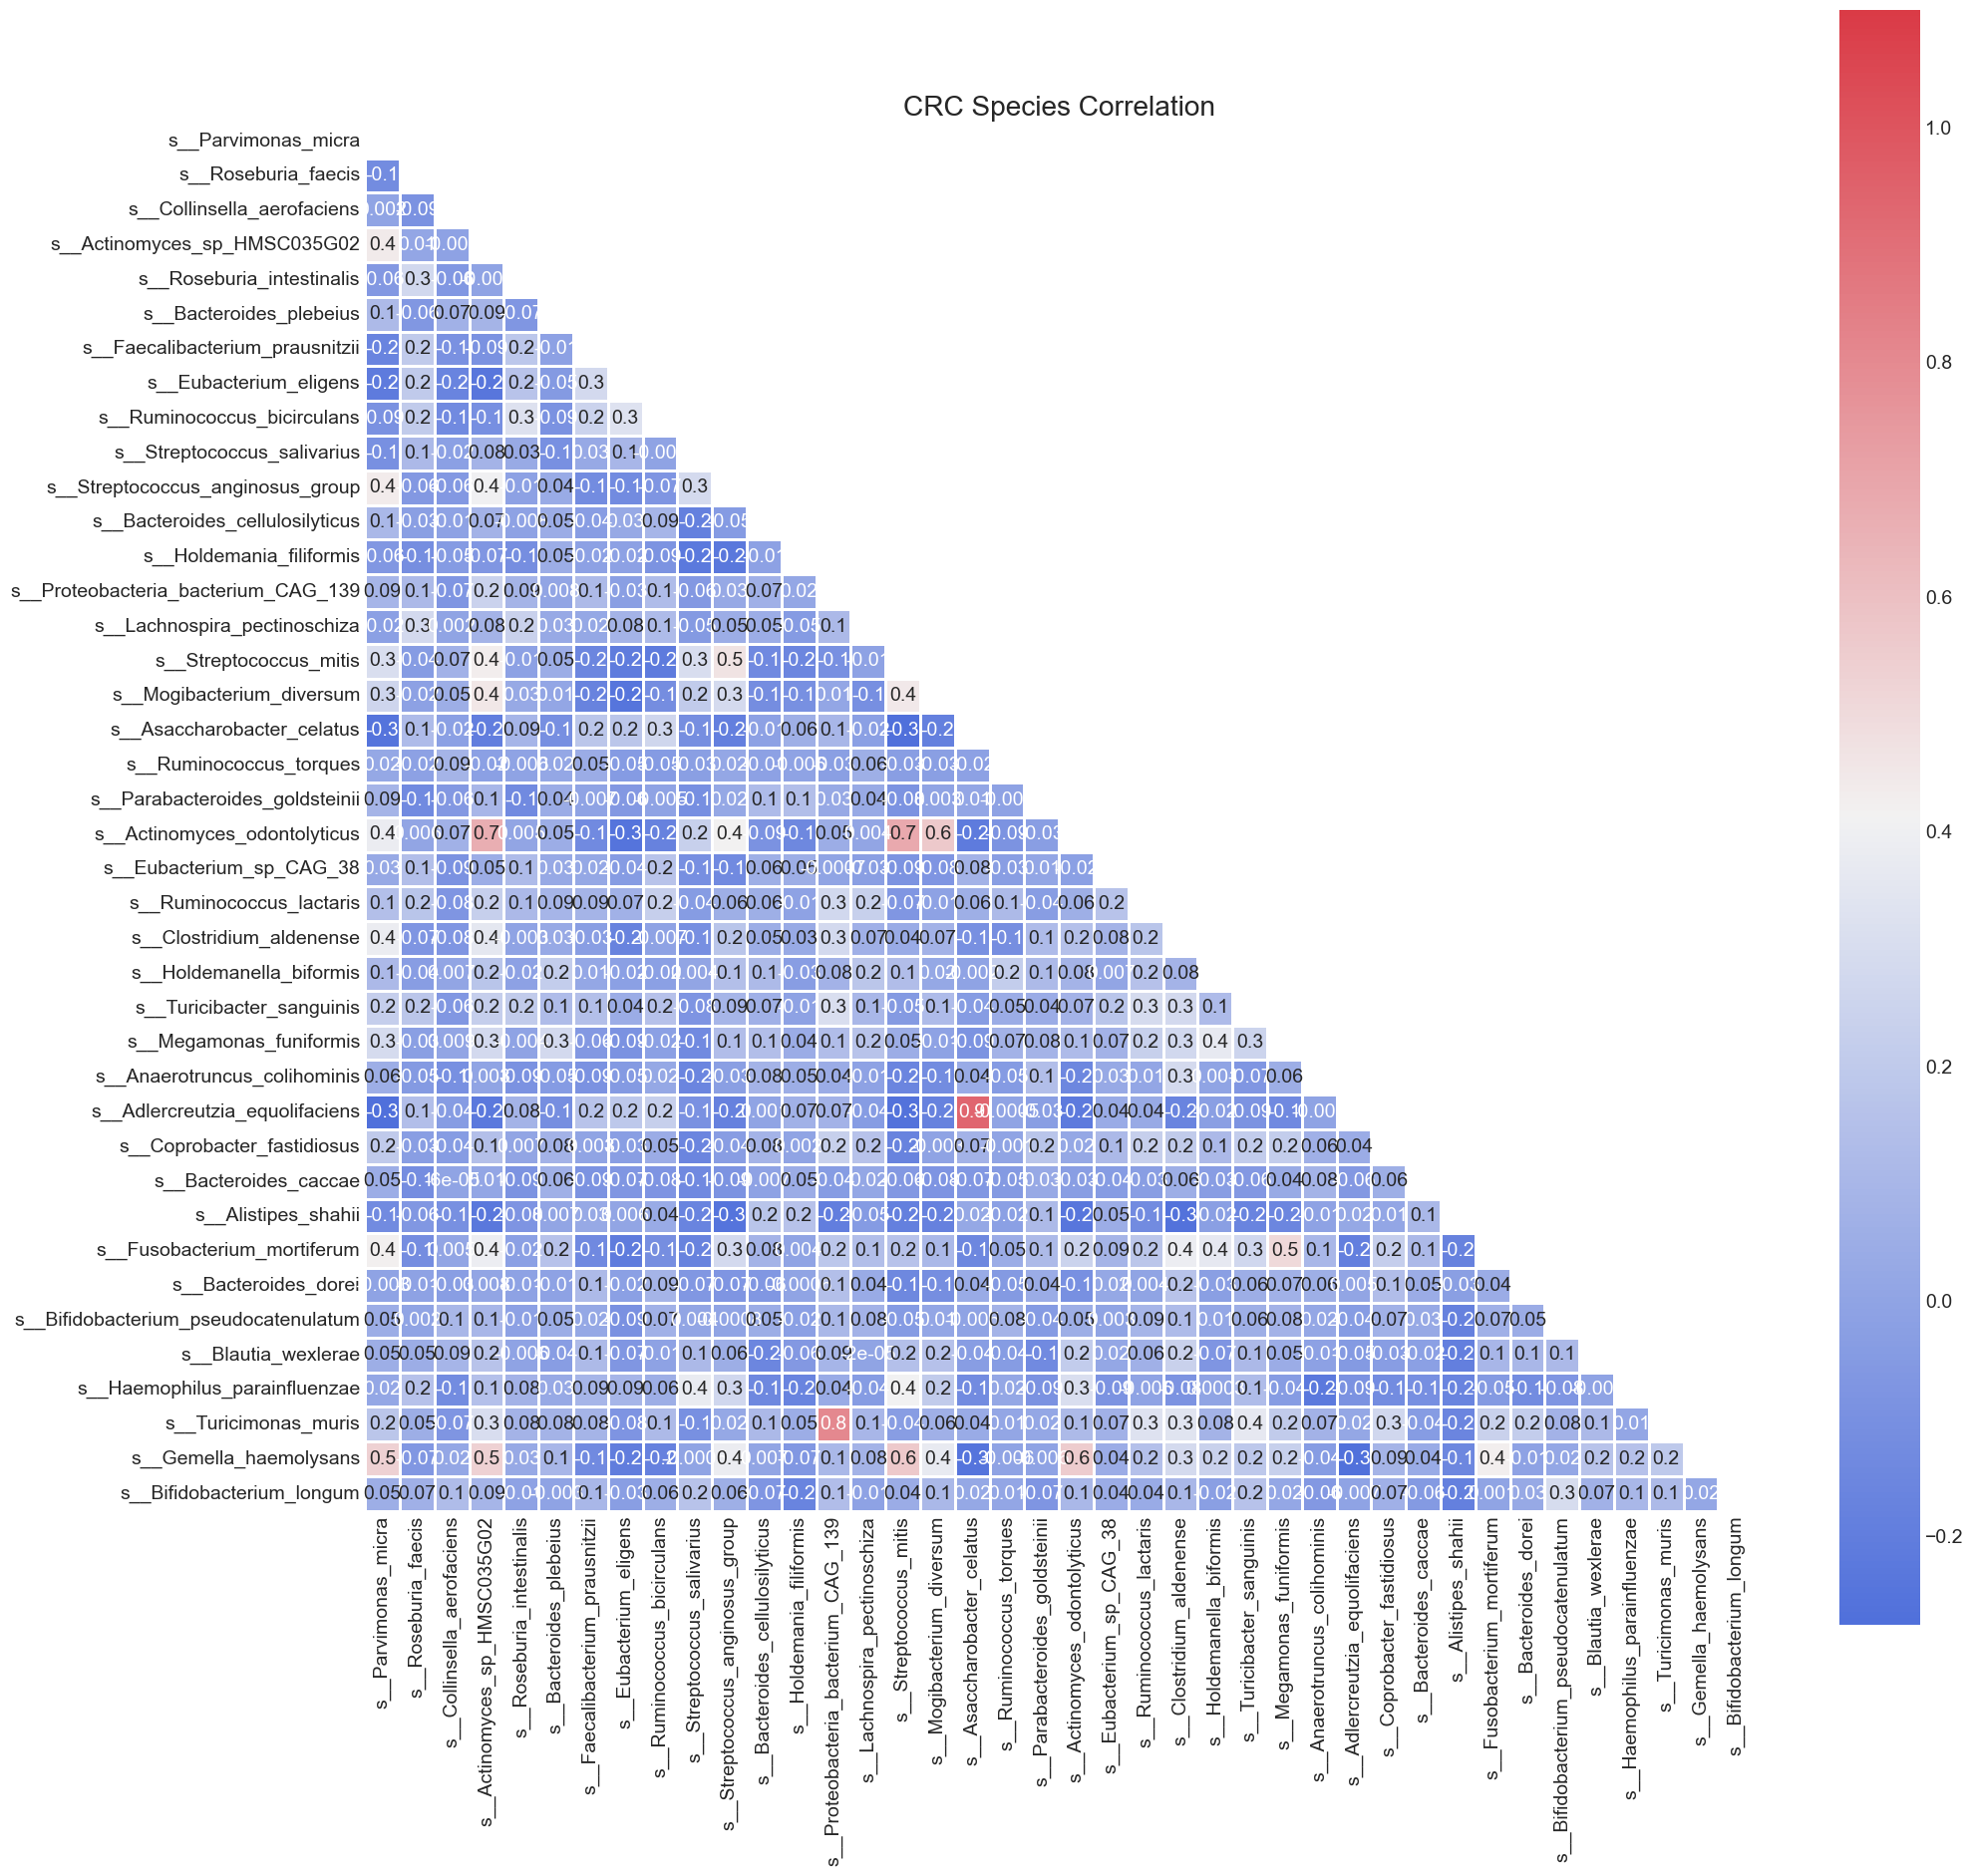

In [56]:
# plot correlation matrix
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')
sns.set_style("white")

# Compute the correlation matrix
data_species = data_signif.iloc[:, 1:data_signif.shape[1]]
corr = data_species.corr(method="spearman")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('CRC Species Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            vmax=1.1, 
            square='square', 
            cmap=cmap, 
            mask=mask, 
            ax=ax,
            annot=True, 
            fmt='.1g',
            linewidths=2)

## A Summary of the significant species here:

1. t-test on microbiota data
2. FDR correction on pvalue of t-test
3. obtain significant species


## Referenece 

1. [How to implement R's p.adjust in Python](https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python/33532498#33532498)
2. [T Test on Multiple Columns in Dataframe](https://stackoverflow.com/questions/71281535/t-test-on-multiple-columns-in-dataframe)